# Tutorial to Work with a GOES-R (Geostationary) ABI Level 2 Data File

This code was written in December 2022 by Dr. Rebekah Esmaili, STC at NOAA/JPSS (rebekah.esmaili@noaa.gov) and Dr. Amy Huff, IMSG at NOAA/NESDIS/STAR (amy.huff@noaa.gov).

This tutorial will demonstrate how to work with an ABI Level 2 netCDF4 file, including how to work with the ABI fixed grid/GOES Imager projection and what aspects to consider when making beautiful composite color (RGB) imagery.

The main steps are:
- Open the file
- Read the global file metadata & the metadata for variables in the file
    - Recognize the GOES Imager fixed grid projection variables
- Combine ABI band data variables to make different types of composite RGB imagery
- Plot composite RGB imagery using the native geostationary map projection
- Save image file

## Step 1-2: Launch Jupyter Notebooks

### Import Python packages

We will use three Python packages (libraries) and two Python modules in this tutorial:
- The **xarray** library is used to work with labelled multi-dimensional arrays
- The **NumPy** library is used to perform array operations
- The **Matplotlib** library is used to make plots
- The **datetime** module is used to manipulate dates and times
- The **pathlib** module is used to set filesystem paths for the user's operating system

In [94]:
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import datetime
from pathlib import Path
from skimage.exposure import adjust_gamma, rescale_intensity
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

### Set directory path and file name for satellite data file

We set the directory path for the satellite data file using the **pathlib** module, which automatically uses the correct format for the user's operating system. This helps avoid errors in situations when more than one person is using the same code file, because Windows uses back slashes in directory paths, while MacOS and Linux use forward slashes. 

More information about the **pathlib** module: https://docs.python.org/3/library/pathlib.html#module-pathlib

To keep things simple for this training, we put the satellite data files we downloaded in the current working directory ("cwd"), i.e., the same Jupyter Notebook folder where this code file is located.

We set the "directory_path" as the current working directory and the "file_name" of the netCDF4 satellite data file, and then set the full path for the data file ("file_id") using **pathlib** syntax.

In [44]:
directory_path = Path.cwd()
file_name = 'OR_ABI-L2-MCMIPM2-M6_G16_s20223362030552_e20223362031017_c20223362031113.nc'
file_id = directory_path / file_name

## Step 3: Understand the structure and contents of the file(s)

### Open satellite data file using xarray & read metadata

We open the satellite data file using "xarray.open_dataset" and then print the file metadata. The contents of a satellite data file are called a "Dataset" in **xarray**, conventionally abbreviated as "ds". 

The global file metadata are listed under "Attributes".

For any of the "Data variables" or "Coordinates", click on the attributes icon (little page) to see array metadata and the data repository icon (little server) to see an array summary.

The satellite data in the file are displayed under "Data variables".  A data variable is called a "DataArray" in **xarray**, conventionally abbreviated as "da". We are going to focus on the Cloud and Moisture Imagery (CMI) for the 16 ABI bands, also called channels (C); for example, "CMI_C01" is the CMI reflectance value for band (channel) 1.  We will also need the information in the "goes_imager_projection" data variable, which are constants that describe the fixed ABI grid for the GOES-16 satellite geostationary projection.

Notice that there is no array for latitude or longitude ing the "Coordinates".  To save file space, ABI L1b and L2 data files do not contain latitude and longitude. 

In [25]:
ds = xr.open_dataset(file_id, engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                                 (y: 500, x: 500,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.117 0.117 ... 0.08907
  * x                                       (x) float64 -0.07277 ... -0.04483
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2022-12-02T20:31:11.3Z
    time_coverage_start:       2022-12-02T20:30:55.2Z
    time_coverage_end:         2022-12-02T20:31:01.7Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        9c8ac194-48e9-47a9-a5b3-8f4ce24e3f5f

## Step 4: Handling data arrays

When you're combining data, it's important that all arrays have the same dimensions. If not, the data needs to be re-gridded. In this example, all the data are the same size (this is not true for all files!). Let's compare channels 1-3:

In [46]:
ds['CMI_C01'].shape, ds['CMI_C02'].shape

((500, 500), (500, 500))

They're both have the same dimensions, so we can continue. For illustrative purposes, lets say we want to coarsen channel 1 by a factor of 2. We could change the size using numpy indexing:

In [48]:
ch1 = ds['CMI_C01']
ch1_resize = ch1[::2,::2]
ch1.shape, ch1_resize.shape

((500, 500), (250, 250))

## Step 5: Create a basic RGB image
### True Color RGB

True color imagery (also called natural color) has delighted both scientists and the public since the beginning of the satellite age. These images are constructed from three layers, which respectively are red, green, and blue. To learn more, check out the [True Color RGB quick guide](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_CIMSSRGB_v2.pdf) from Colorado State University's Cooperative Institute for Research in the Atmosphere.

We cons
GOES-16 channel list: https://www.goes-r.gov/mission/ABI-bands-quick-info.html


|Color|central wavelength (µm)|channel| regrid | min - max | gamma |
|----|---|---|---|---|---|
|Red |0.64|2| yes |all|1|
|Green|0.45\*Red + 0.1\*Veggie + 0.45\*Blue|2,3,1| yes| all|1|
|Blue|0.47|1|no|all |1|

The GOES-R series ABI sensor does not have a channel that detects the green wavelengths. Instead, it can be derived from a linear relationship between the red, blue, and another nicknamed the veggie channel. Let extract these data arrays from our dataset.

In [31]:
ch1 = ds.CMI_C01
ch2 = ds.CMI_C02
ch3 = ds.CMI_C03

Before we combine any arrays, make sure they're the same size!

In [32]:
# Check if all components are the same shape
ch1.shape, ch2.shape, ch3.shape

((500, 500), (500, 500), (500, 500))

Use the formula in the table above to linearly combine the three arrays

In [49]:
green = 0.45*ch2 + 0.1*ch3 + 0.45*ch1

We can use np.stack to combine the three arrays into a single 3D array. We want the array order to be (lon,lat,color). The axis options says which direction they should be stacked; if axis=0, the dimensions will be (3,500,500), if axis=1, the dimensions are (500,3,500), and if axis=2, the dimensions are (500,500,3). This last one is what we want.

In [60]:
rgb = np.stack([ch2, green, ch1], axis=2)
rgb.shape

(500, 500, 3)

Let's make a quick plot using imshow. Each of the three z layers will be respectively converted into red, green, and blue to create a color image.

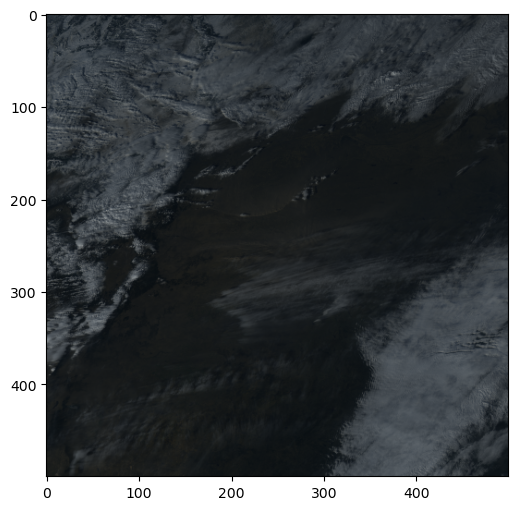

In [61]:
plt.figure(figsize=[6,6])
plt.imshow(rgb)
plt.show()

### Dust RGB

Just because we're working in RGB space doesn't limit us to only using the red, green, blue channels. We can combine any of the ABI channels to produce imagery. Since some channels are more sensitive to atmospheric constituents than others, RGB images can help distinguish natural features.

Let's create a dust RGB image of the same scene next.

Dust RGB quick guide: https://rammb.cira.colostate.edu/training/visit/quick_guides/Dust_RGB_Quick_Guide.pdf

|Color|central wavelength (µm)|channel| regrid | min - max (K) | gamma |
|----|---|---|---|---|---|
|Red |12.3 - 10.3|15 - 13| no | -6.7 to 2.6 |1|
|Green|11.2 - 8.2|14 - 11| no | -0.5 to 20.0 |2.5|
|Blue|10.3 |13| no | 261.2 to 288.7 |1|


In [40]:
ch11 = ds.CMI_C11
ch13 = ds.CMI_C13
ch14 = ds.CMI_C14
ch15 = ds.CMI_C15

In [88]:
img = ch15-ch13
# Rescale and adjust gamma
# np.clip()
img = rescale_intensity(img, in_range=(-6.7, 2.6), out_range=(0,1))
red = adjust_gamma(img, 1.0)

img = ch14-ch11
# Rescale and adjust gamma
img = rescale_intensity(img, in_range=(-0.5, 20.0), out_range=(0,1))
green = adjust_gamma(img, 2.5)

img = ch13
# Rescale and adjust gamma
img = rescale_intensity(img, in_range=(261.2, 288.7), out_range=(0,1))
blue = adjust_gamma(img, 1.0)

In [89]:
rgb = np.stack([red, green, blue], axis=2)

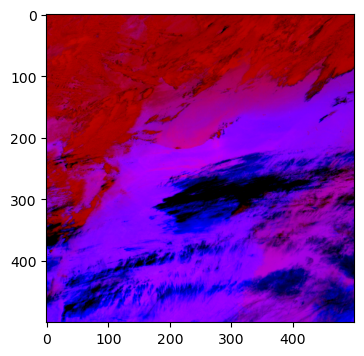

In [90]:
plt.figure(figsize=[4,4])
plt.imshow(rgb)
plt.show()

### Exercise: Create a Airmass RGB image

[Airmass RGB](https://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_AirMassRGB_final.pdf) are used by meteorologists to easily display regions of polar and tropical air masses.

Below is the recipe:

|Color|central wavelength (µm)|channel | min - max (K) | gamma |
|----|---|---|---|---|
|Red |6.2 – 7.3|8, 10 |-26.2 to 0.6 |1|
|Green|9.6 – 10.3|12, 13| -43.2 to 6.7 |1|
|Blue|6.2 (inverted)|8|-29.25 to -64.65 |1|

Construct an image below, some of the code is provided:

## Step 6: Working with map projections

Now we can proceed to plotting our satellite data on a map. 

We set up a figure in **Matplotlib** and add "geoaxes" with a map projection using **Cartopy**. There are many different map projection options. Our VIIRS Level 3 gridded data is a global dataset, so we are focusing on global map projections for this tutorial. 

Here is a list of [**Cartopy**](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html) map projections. The VIIRS AOD notebook (viirs_aod.ipynb) walks through several examples of these in greater detail.

You may have noticed that this file does not have latitude and longitude coordinates; many of the GOES ABI products are stored on a geostationary grid. We can extract information about the GOES satellite orbit directly from the netcdf file to make our plot, which in turn can be used by Cartopy to project onto a geostationary grid.

In [67]:
proj_var = ds.goes_imager_projection

sat_height = proj_var.perspective_point_height
semi_major = proj_var.semi_major_axis
semi_minor = proj_var.semi_minor_axis

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)

The plotting function argument **"transform=ccrs.Geostationary()"** tells **Cartopy** that the rgb data are in geostationary coordinates. This argument **must** be included when plotting satellite data that are in geographic coordinates, or the data will not plot correctly on the map projection.

Recall that geostationary satellites are always looking at a fixed point on the Earth's surface. The fixed point and satellite height are different on GOES-16/-17/-18 and on international partner satellites, like Meteosat and Himawari. The central latitude is included in the file, but thus far, all GOES satellites are centered on the equator, and the default value for central_latitude in the function is 0.

In [68]:
central_lon = proj_var.longitude_of_projection_origin
crs = ccrs.Geostationary(central_longitude=central_lon, satellite_height=sat_height, globe=globe)

It's also important to define the extent of the image. This tells Cartopy the boundaries of the image (versus that of the map). We do this by multiplying the x and y values (which is essentially the viewing angle of the satellite) by the height of the satellite. The smallest and largest values of each show the extent.

In [72]:
X = ds['x']*sat_height
Y = ds['y']*sat_height
imgExtent = (X.min(), X.max(), Y.min(), Y.max())

Finally, let's make a plot! You can switch the projection to Plate Carree by commenting out the second line. 

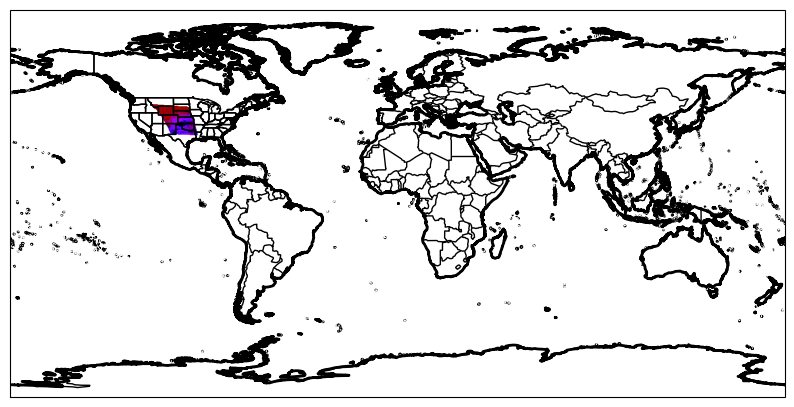

In [102]:
proj_to = crs
# proj_to = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=proj_to)

ax.coastlines('10m', linewidth=2)
ax.imshow(rgb, origin='upper', extent=imgExtent, transform=crs)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

plt.show()

## Step 7: Professional touches

In [114]:
ds.attrs

{'naming_authority': 'gov.nesdis.noaa',
 'Conventions': 'CF-1.7',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'standard_name_vocabulary': 'CF Standard Name Table (v35, 20 July 2016)',
 'institution': 'DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services',
 'project': 'GOES',
 'production_site': 'NSOF',
 'production_environment': 'OE',
 'spatial_resolution': '2km at nadir',
 'orbital_slot': 'GOES-East',
 'platform_ID': 'G16',
 'instrument_type': 'GOES-R Series Advanced Baseline Imager (ABI)',
 'scene_id': 'Mesoscale',
 'instrument_ID': 'FM1',
 'dataset_name': 'OR_ABI-L2-MCMIPM2-M6_G16_s20223362030552_e20223362031017_c20223362031113.nc',
 'iso_series_metadata_id': '8c9e8150-3692-11e3-aa6e-0800200c9a66',
 'keywords_vocabulary': 'NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0',
 'title': 'ABI L2 Cloud and Moisture Imagery',
 'summ

In [149]:
platform = ds.platform_ID + ' ' + ds.title[0:3]

dtinfo_s = ds.time_coverage_start[0:16].replace('T',' ')
dtinfo_e = ds.time_coverage_end[0:16].replace('T',' ')

dt_scan = datetime.datetime.strptime(dtinfo_s, '%Y-%m-%d %H:%M')
date_s = dt_scan.strftime('%d %b %Y')
time_s = dt_scan.strftime('%H:%M')

# time = + str(file_name).split('_')[-3][8:10] + ':' + str(file_name).split('_')[-3][10:12] + ' UTC'

composite = 'Dust RGB Composite'
formula = r'$Red = BT_{12.3\mu m}-BT_{10.3\mu m} \ \ \ Green = BT_{11.2\mu m}-BT_{8.4\mu m} \ \ \ Blue = BT_{10.3\mu m}$'

plot_title = platform + ' ' + composite + ' ' + time_s + '\n' + formula

In [150]:
plot_title

'G16 ABI Dust RGB Composite 20:30\n$Red = BT_{12.3\\mu m}-BT_{10.3\\mu m} \\ \\ \\ Green = BT_{11.2\\mu m}-BT_{8.4\\mu m} \\ \\ \\ Blue = BT_{10.3\\mu m}$'

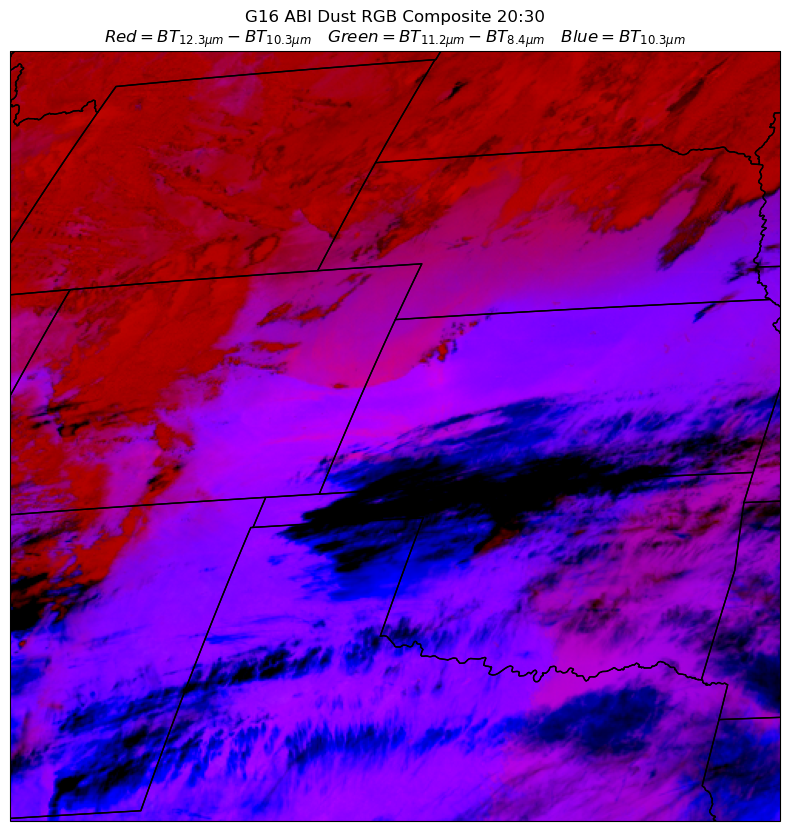

In [151]:
proj_to = crs
# proj_to = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=proj_to)

ax.coastlines('10m', linewidth=2)
ax.imshow(rgb, origin='upper', extent=imgExtent, transform=crs)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

plt.title(plot_title)
plt.show()